In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import process_time 
import pandas as pd
import optperfprofpy
import warnings
from scipy.sparse import dia_matrix


warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
def F1(x):
    return np.array([2 * x_i - np.sin(np.abs(x_i)) for x_i in x])


def F2(x):
    f_1 = 2 * x[0] + np.sin(x[0]) - 1
    f_i = [-2 * x[i - 1] + 2 * x[i] + np.sin(x[i]) - 1 for i in range(1, len(x) - 1)]
    f_n = 2 * x[-1] + np.sin(x[-1]) - 1
    return np.array([f_1] + f_i + [f_n])


def F3(x):
    h = 1 / (len(x) + 1)
    f_1 = x[0] - np.exp(np.cos(h * (x[0] + x[1])))
    f_i = [x[i] - np.exp(np.cos(h * (x[i - 1] + x[i] + x[i + 1]))) for i in range(1, len(x) - 1)]
    f_n = x[-1] - np.exp(np.cos(h * (x[-2] + x[-1])))
    return np.array([f_1] + f_i + [f_n])


def F4(x):
    return np.array([np.exp(x_i) - 1 for x_i in x])


def F5(x):
    f_1 = 2.5 * x[0] + x[1] - 1
    f_i = [x[i - 1] + 2.5 * x[i] + x[i + 1] - 1 for i in range(1, len(x) - 1)]
    f_n = x[-2] + 2.5 * x[-1] - 1
    return np.array([f_1] + f_i + [f_n])


def F6(x):
    n = len(x)
    return np.array([np.log(x_i + 1) - x_i / n for x_i in x])


def F7(x):
    f_1 = x[0] * (x[0] ** 2 + x[1] ** 2) - 1
    f_i = [x[i] * (x[i - 1] ** 2 + 2 * (x[i] ** 2) + x[i + 1] ** 2) - 1 for i in range(1, len(x) - 1)]
    f_n = x[-1] * (x[-2] ** 2 + x[-1] ** 2)
    return np.array([f_1] + f_i + [f_n])


def F8(x):
    n = len(x)
    ex = np.ones(n)
    data = np.array([-ex, 2 * ex, -ex])
    offsets = np.array([-1, 0, 1])
    A = dia_matrix((data, offsets), shape=(n, n))
    
    g = np.array([np.exp(x_i) - 1 for x_i in x])

    return A @ x + g

In [ ]:
def feval(c):
  c+=1
  return c

In [ ]:
def line_search_DLPM(F, x_k, d_k, sigma, r, count):
    alpha = 1
    while True:
        f_x_next = F(x_k + alpha * d_k)
        count = feval(count)
        if - f_x_next.T @ d_k >= sigma * alpha * np.linalg.norm(f_x_next) * (np.linalg.norm(d_k) ** 2):
            break
        alpha = alpha * r
    return alpha, count

In [ ]:
def line_search_FCG(F, x_k, d_k, sigma, r, rho, count):
    alpha = 1
    while True:
        f_x_next = F(x_k + rho * alpha * d_k)
        count = feval(count)
        if - f_x_next.T @ d_k >= sigma * rho * alpha * (np.linalg.norm(d_k)**2):
            break
        alpha = alpha * r
    return alpha, count


In [ ]:
def DLPM(F, x0):
    
    r = 0.6  # 0 < r < 1
    sigma = 0.01  # sigma > 0
    epsilon = 10e-6  # epsilon > 0
    count = 0

    p = 0.8
    q = -0.1

    x_k = np.copy(x0)
    f_k = F(x_k)
    count = feval(count)

    fs = [np.linalg.norm(f_k)]

    for k in range(5000):
        if k % 500 == 0 and k!= 0:
            print('Iteration: ', k)

        f_k_last = np.copy(f_k)

        # compute direction: d
        if k == 0:
            d = -f_k
        else:
            t = p * (np.linalg.norm(y_k_last) ** 2) / (s_k_last.T @ y_k_last) - q * (s_k_last.T @ y_k_last) / (
                    np.linalg.norm(s_k_last) ** 2)
            Beta = (f_k.T @ y_k_last) / (y_k_last.T @ d) - t * (f_k.T @ s_k_last) / (y_k_last.T @ d)
            d = -f_k + Beta * d

        if np.linalg.norm(d) == 0:
            return np.linalg.norm(f_k), x_k, k, fs, count

        alpha, count = line_search_DLPM(F, x_k, d, sigma, r, count)

        z_k = x_k + alpha * d
        f_z_k = F(z_k)
        count = feval(count)

        if np.linalg.norm(f_z_k) == 0:
            return np.linalg.norm(f_k), x_k, k, fs, count

        x_k = x_k - (f_z_k.T @ (x_k - z_k) * f_z_k) / (np.linalg.norm(f_z_k) ** 2)

        f_k = F(x_k)
        count = feval(count)

        if np.linalg.norm(f_k) <= epsilon:
            return np.linalg.norm(f_k), x_k, k, fs, count

        y_k_last = f_k - f_k_last
        s_k_last = alpha * d

        fs.append(np.linalg.norm(f_k))

In [ ]:
def FCG(F, x0):
    r = 0.5
    sigma = 0.01
    t = 1
    rho = 1
    epsilon = 10e-6
    count = 0 

    x_k = np.copy(x0)
    f_k = F(x_k)
    count = feval(count)

    fs = [np.linalg.norm(f_k)]

    for k in range(5000):
        if k % 500 == 0 and k!= 0:
            print('Iteration: ', k)

        # compute direction: d
        if k == 0:
            d = -f_k
        else:
            Beta = t * np.linalg.norm(f_k) / (np.linalg.norm(d))
            d = -(1 + Beta * (f_k.T @ d) / (np.linalg.norm(f_k) ** 2)) * f_k + Beta * d

        if np.linalg.norm(d) == 0:
            return np.linalg.norm(f_k), x_k, k, fs, count

        alpha, count = line_search_FCG(F, x_k, d, sigma, r, rho, count)

        z_k = x_k + alpha * d
        f_z_k = F(z_k)
        count = feval(count)

        if np.linalg.norm(f_z_k) == 0:
            return np.linalg.norm(f_k), x_k, k, fs, count

        x_k = x_k - (f_z_k.T @ (x_k - z_k) * f_z_k) / (np.linalg.norm(f_z_k) ** 2)

        f_k = F(x_k)
        count = feval(count)

        if np.linalg.norm(f_k) <= epsilon:
            return np.linalg.norm(f_k), x_k, k, fs, count

        fs.append(np.linalg.norm(f_k))

    return np.linalg.norm(f_k), x_k, k, fs, count


In [ ]:
n = 10000
x0 = np.ones((n, 1))
# F = F3

DLPM: norm_f: 2.622956581023925e-06  iterations: 7
Processing time in DLPM in seconds =  0.9484253590000002
Number of function evaluations =  26


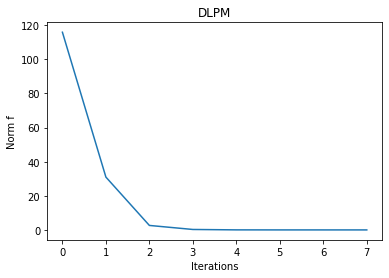

In [ ]:
t1_start = process_time()
norm_f, final_x, iterations, fs, count = DLPM(F1, x0)
t1_stop = process_time()

print(f'DLPM: norm_f: {norm_f}  iterations: {iterations}')
print("Processing time in DLPM in seconds = ", t1_stop-t1_start)
print("Number of function evaluations = ",count)

plt.plot(fs)
plt.title("DLPM")
plt.xlabel("Iterations")
plt.ylabel("Norm f")

plt.show()

FCG: norm_f: 9.648176422304654e-06  iterations: 22
Processing time in FCG in seconds =  3.287028809
Number of function evaluations =  93


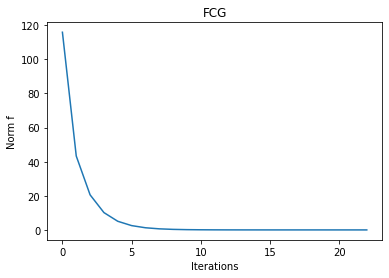

In [ ]:
t2_start = process_time()
norm_f, final_x, iterations, fs, count = FCG(F1, x0)
t2_stop = process_time()

print(f'FCG: norm_f: {norm_f}  iterations: {iterations}')
print("Processing time in FCG in seconds = ", t2_stop-t2_start)
print("Number of function evaluations = ",count)

plt.figure()
plt.plot(fs)
plt.title('FCG')
plt.xlabel("Iterations")
plt.ylabel("Norm f")

plt.show()


In [ ]:
# initial points
n1 = 10000
n2 = 100000

x0_1 = 1 * np.ones((n1, 1))
x0_2 = -0.5 * np.ones((n1, 1))
x0_3 = 0.1 * np.ones((n1, 1))
x0_4 = -10 * np.ones((n1, 1))
x0_5 = -1 * np.ones((n2, 1))
x0_6 = 0.5 * np.ones((n2, 1))
x0_7 = -0.1 * np.ones((n2, 1))
x0_8 = 10 * np.ones((n2, 1))

x0_9 = -1 * np.ones((n1, 1))

p1 = [x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x0_7, x0_8]
p2 = [x0_1, x0_2, x0_3, x0_6, x0_7]
p3 = [x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x0_7, x0_8]
p4 = [x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x0_7]
p5 = [x0_1, x0_2, x0_3, x0_4, x0_5, x0_6, x0_7, x0_8]
p6 = [x0_1, x0_2, x0_3, x0_6, x0_7, x0_8]
p7 = [x0_1, x0_9, x0_7]
p8 = [x0_3, x0_7]

p_inits = [p1, p3, p4, p5, p6, p7, p8]


In [ ]:
df_perprof = []
for i, f in enumerate(['F1', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']):
  print(f)
  inits = p_inits[i]
  for x0 in inits:
    str_x0 = f'{x0[0][0]}, n={x0.shape[0]}'
    print(str_x0)
    for method in ['DLPM', 'FCG']:
      # iter, t, feval, fnorm = eval(method)(eval(f))
      t_start = process_time()
      norm_f, final_x, iterations, fs, count = eval(method)(eval(f), x0)
      t_stop = process_time()
      # iter, t, feval, fnorm = 1, 2, 3, 4
      df_perprof.append([f, str_x0, method, iterations, t_stop-t_start, count, norm_f])
  print()

# df
df_perprof = pd.DataFrame(df_perprof, columns=['F', 'x0', 'Method', 'ITER', 'Time', 'Feval', 'Norm'])
df_perprof

F1
1.0, n=10000
-0.5, n=10000
0.1, n=10000
-10.0, n=10000
-1.0, n=100000
0.5, n=100000
-0.1, n=100000
10.0, n=100000

F3
1.0, n=10000
-0.5, n=10000
0.1, n=10000
-10.0, n=10000
-1.0, n=100000
0.5, n=100000
-0.1, n=100000
10.0, n=100000

F4
1.0, n=10000
-0.5, n=10000
0.1, n=10000
-10.0, n=10000
-1.0, n=100000
0.5, n=100000
-0.1, n=100000

F5
1.0, n=10000
-0.5, n=10000
0.1, n=10000
-10.0, n=10000
-1.0, n=100000
0.5, n=100000
-0.1, n=100000
10.0, n=100000

F6
1.0, n=10000
-0.5, n=10000
0.1, n=10000
0.5, n=100000
-0.1, n=100000
10.0, n=100000

F7
1.0, n=10000
Iteration:  500
-1.0, n=10000
Iteration:  500
-0.1, n=100000

F8
0.1, n=10000
-0.1, n=100000



,F,x0,Method,ITER,Time,Feval,Norm
0,F1,"1.0, n=10000",DLPM,7,0.921052,26,2.622957e-06
1,F1,"1.0, n=10000",FCG,22,3.395218,93,9.648176e-06
2,F1,"-0.5, n=10000",DLPM,5,1.131971,32,9.901152e-07
3,F1,"-0.5, n=10000",FCG,11,2.121534,61,9.336618e-06
4,F1,"0.1, n=10000",DLPM,6,0.809523,23,3.980382e-06
...,...,...,...,...,...,...,...
79,F7,"-0.1, n=100000",FCG,389,2122.650864,1995,8.263691e-06
80,F8,"0.1, n=10000",DLPM,32,5.822476,227,3.159797e-06
81,F8,"0.1, n=10000",FCG,74,9.612726,383,7.075653e-06
82,F8,"-0.1, n=100000",DLPM,29,106.736387,250,7.269918e-06


Number of problems per solver:  42
Number of problems per solver:  42
Number of problems per solver:  42


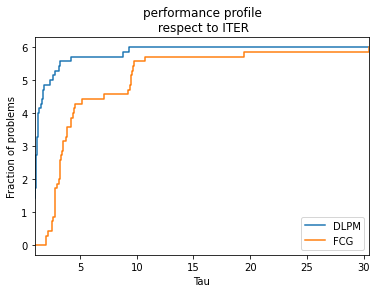

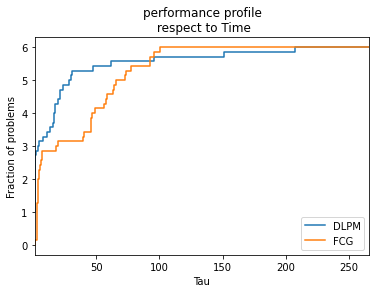

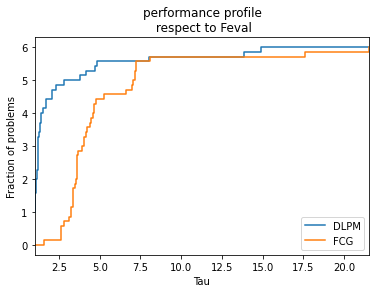

In [ ]:
objectives = ['ITER', 'Time', 'Feval']
for objective in objectives:
  taus, solver_vals, solvers, transformed_data = optperfprofpy.calc_perprof(df_perprof, ['F'], [objective], ['Method'])
  optperfprofpy.draw_simple_pp(taus, solver_vals, solvers)
  plt.title(f'performance profile\n respect to {objective}')

  

In [ ]:
from IPython.display import display
for i, f in enumerate(['F1', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']):
    table = df_perprof[df_perprof['F'] == f].pivot_table(index='x0', columns='Method', values=['ITER', 'Time', 'Feval', 'Norm'])
    display(table)


Feval      ITER  ...      Norm        Time           
Method          DLPM  FCG DLPM  ...       FCG        DLPM        FCG
x0                              ...                                 
-0.1, n=100000    32   61    5  ...  0.000006   17.033628  32.557636
-0.5, n=10000     32   61    5  ...  0.000009    1.131971   2.121534
-1.0, n=100000    47   71    7  ...  0.000004   24.802898  37.925095
-10.0, n=10000   121   65   16  ...  0.000005    4.189922   2.233993
0.1, n=10000      23   81    6  ...  0.000010    0.809523   2.803902
0.5, n=100000     26   97    7  ...  0.000009   14.186451  51.533784
1.0, n=10000      26   93    7  ...  0.000010    0.921052   3.395218
10.0, n=100000   405  111   46  ...  0.000007  215.644637  58.900229

[8 rows x 8 columns]

Feval      ITER          Norm                  Time           
Method          DLPM  FCG DLPM FCG      DLPM       FCG        DLPM        FCG
x0                                                                           
-0.1, n=100000    85  109   16  26  0.000008  0.000007   68.946873  80.428400
-0.5, n=10000     37  101    9  24  0.000008  0.000010    2.080523   5.697046
-1.0, n=100000   117  109   20  26  0.000008  0.000009   86.398470  80.698265
-10.0, n=10000   125  109   21  26  0.000008  0.000009    7.064337   6.142025
0.1, n=10000      31  101    8  24  0.000008  0.000008    1.757256   5.723672
0.5, n=100000     70  109   14  26  0.000008  0.000005   52.031798  80.484686
1.0, n=10000      30  101    8  24  0.000002  0.000005    1.881800   5.671424
10.0, n=100000   242  113   34  27  0.000008  0.000009  177.144114  83.013157

Feval      ITER          Norm                 Time           
Method          DLPM  FCG DLPM FCG      DLPM       FCG       DLPM        FCG
x0                                                                          
-0.1, n=100000    22   76    6  18  0.000002  0.000006   9.304954  32.201806
-0.5, n=10000     25   71    7  17  0.000002  0.000008   0.622541   1.750117
-1.0, n=100000    38   74   10  18  0.000002  0.000009  15.896683  31.225475
-10.0, n=10000    58  101   18  27  0.000003  0.000009   1.429514   2.457476
0.1, n=10000      23   81    6  19  0.000003  0.000009   0.558157   1.954411
0.5, n=100000     31   97    8  23  0.000002  0.000006  13.114242  41.026883
1.0, n=10000      28   89    7  21  0.000005  0.000006   0.848549   2.186114

Feval      ITER           Norm                  Time            
Method          DLPM  FCG DLPM  FCG      DLPM       FCG        DLPM         FCG
x0                                                                             
-0.1, n=100000   146  876   20  165  0.000008  0.000008   90.091129  535.523620
-0.5, n=10000    149  867   22  163  0.000007  0.000006    6.452829   37.458624
-1.0, n=100000   121  848   17  159  0.000007  0.000008   73.868643  521.084737
-10.0, n=10000   253  970   31  183  0.000004  0.000009   10.870754   42.166980
0.1, n=10000     190  799   30  150  0.000008  0.000006    8.151117   34.209492
0.5, n=100000    143  851   19  161  0.000004  0.000008   87.144384  517.310199
1.0, n=10000     124  875   18  166  0.000009  0.000007    5.611128   37.886690
10.0, n=100000   577  871   57  163  0.000006  0.000006  355.429512  537.881056

Feval     ITER          Norm                  Time           
Method          DLPM FCG DLPM FCG      DLPM       FCG        DLPM        FCG
x0                                                                          
-0.1, n=100000    23  89    6  21  0.000010  0.000007   14.398838  55.666832
-0.5, n=10000     23  89    6  21  0.000005  0.000006    1.046551   4.017991
0.1, n=10000      19  68    5  16  0.000005  0.000007    0.848756   3.007588
0.5, n=100000     29  79    8  19  0.000002  0.000005   18.142798  49.908320
1.0, n=10000      25  62    7  15  0.000009  0.000009    1.298770   2.770164
10.0, n=100000   283  85   47  22  0.000002  0.000005  176.304551  52.494168

Feval       ITER  ...      Norm        Time             
Method          DLPM   FCG DLPM  ...       FCG        DLPM          FCG
x0                               ...                                   
-0.1, n=100000   144  1995   20  ...  0.000008  151.476741  2122.650864
-1.0, n=10000    177  3105   23  ...  0.000009   15.746619   273.837773
1.0, n=10000     159  3102   23  ...  0.000009   14.016826   271.160795

[3 rows x 8 columns]

Feval       ITER  ...      Norm        Time            
Method          DLPM   FCG DLPM  ...       FCG        DLPM         FCG
x0                               ...                                  
-0.1, n=100000   250  1058   29  ...  0.000010  106.736387  448.745977
0.1, n=10000     227   383   32  ...  0.000007    5.822476    9.612726

[2 rows x 8 columns]